In [1]:
import random
import csv
from datetime import datetime, timedelta
import re

random.seed(42)

# =========================================================
# BASE TEMPLATES (INCLUDING AMBIGUOUS ONES)
# =========================================================
base_texts = [
    ("The road near {loc} is full of deep potholes. Tractors are breaking down daily", "pothole", "high", "delayed_transport"),
    ("Heavy rain washed out rural road near {loc}; carts stuck since dawn", "flooding", "high", "delayed_transport"),
    ("Bridge approaching {loc} cracked badly; trucks loaded with produce are forced to pause", "bridge_damage", "high", "delayed_transport"),
    ("Tree debris blocking farm road near {loc}. Vehicles stalled", "blockage", "medium", "delayed_transport"),
    ("Landslide has cut off mountain trail to orchards near {loc}", "landslide", "critical", "crop_loss_risk"),
    ("Water logging on farm service road to {loc}, tractors cannot reach fields", "flooding", "medium", "delayed_transport"),
    ("Big potholes near {loc} slowing grain transport", "pothole", "medium", "delayed_transport"),
    ("Small bridge near {loc} showing cracks; urgent safety risk", "bridge_damage", "high", "delayed_transport"),
    ("Fallen tree blocking access to {loc}, livestock movement paused", "blockage", "high", "livestock_risk"),
    ("Landslide debris covering dirt road near {loc}", "landslide", "high", "delayed_transport"),

    # Ambiguous / overlapping semantics
    ("Road near {loc} has huge holes filled with water after rain, vehicles slipping badly", "pothole", "high", "delayed_transport"),
    ("Mudslide from heavy downpour buried the path to {loc}, everything is soaked", "landslide", "medium", "crop_loss_risk"),
    ("Cracked surface on bridge to {loc} with water seeping through, looks unstable", "bridge_damage", "high", "delayed_transport"),
    ("Debris from fallen branches and rocks blocking {loc} route after storm", "blockage", "medium", "delayed_transport"),
    ("Overflowing stream eroded the road edge near {loc}, dirt giving way", "flooding", "high", "delayed_transport"),
]

# =========================================================
# METADATA
# =========================================================
locations = [
    "Sunderpur", "Latur", "Erode", "Purulia", "Nagpur", "Kumargram",
    "Nawada", "Barmer", "Theni", "Meerut", "Katihar", "Akola",
    "Cotton service lane", "Harvest lane", "Mango orchard rd"
]

districts_states = [
    ("Hisar","Haryana"),("Sitapur","Uttar Pradesh"),("Rampur","Uttar Pradesh"),
    ("Raichur","Karnataka"),("Nadia","West Bengal"),("Shimla","Himachal Pradesh"),
    ("Mandya","Karnataka"),("Gonda","Uttar Pradesh"),("Sehore","Madhya Pradesh")
]

source_types = ["twitter", "news", "civic_app"]
urgency_map = {"low":1, "medium":3, "high":4, "critical":5}

# =========================================================
# CONFUSION & LABEL NOISE
# =========================================================
LABEL_CONFUSION = {
    "pothole": ["flooding", "bridge_damage"],
    "flooding": ["blockage"],
    "blockage": ["flooding", "landslide"],
    "bridge_damage": ["pothole"],
    "landslide": ["blockage"]
}

def inject_label_noise(hazard, prob=0.10):
    if random.random() < prob:
        return random.choice(LABEL_CONFUSION.get(hazard, [hazard]))
    return hazard

# =========================================================
# TEXT NOISE FUNCTIONS
# =========================================================
def inject_typo(word):
    if len(word) < 4:
        return word
    w = list(word)
    i = random.randint(0, len(w)-2)
    w[i], w[i+1] = w[i+1], w[i]
    return "".join(w)

def slang(word):
    mapping = {
        "road":"rd", "bridge":"brdg", "vehicle":"veh", "transport":"xport",
        "farm":"frm", "farmers":"frmrs", "blocked":"blckd", "flooded":"flodd",
        "potholes":"pothl", "cracked":"crkd", "landslide":"slide"
    }
    return mapping.get(word.lower(), word)

def inject_confusing_words(text, hazard):
    confusion_words = {
        "pothole": ["water", "mud", "slippery"],
        "flooding": ["cracks", "holes", "sink"],
        "bridge_damage": ["debris", "fallen"],
        "blockage": ["soil", "slide"],
        "landslide": ["overflow", "wet"]
    }
    words = text.split()
    out = []
    for w in words:
        if random.random() < 0.15:
            out.append(random.choice(confusion_words.get(hazard, [])))
        out.append(w)
    return " ".join(out)

def grammar_noise(text):
    if random.random() < 0.1:
        text = re.sub(r"\b(the|a|an)\b", "", text, count=1)
    if random.random() < 0.05:
        words = text.split()
        i = random.randint(0, len(words)-1)
        words.insert(i, words[i])
        text = " ".join(words)
    return text

def add_noise(text, hazard, severity=0.25):
    text = inject_confusing_words(text, hazard)
    text = grammar_noise(text)

    words = []
    for w in text.split():
        r = random.random()
        if r < severity / 3:
            words.append(inject_typo(w))
        elif r < 2 * severity / 3:
            words.append(slang(w))
        else:
            words.append(w)

    text = " ".join(words)

    if random.random() < 0.05:
        text += "..."
    if random.random() < 0.05:
        text += "!!"

    return text

# =========================================================
# DATE
# =========================================================
def random_date(start, end):
    dt = start + timedelta(days=random.randint(0, (end - start).days))
    return dt.strftime("%Y-%m-%d")

# =========================================================
# DATASET CREATION
# =========================================================
start_dt = datetime.strptime("2024-08-01", "%Y-%m-%d")
end_dt   = datetime.strptime("2024-08-25", "%Y-%m-%d")

with open("road_hazard_reports_final_noisy_1000.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "report_id","raw_text","hazard_type","severity","agri_impact",
        "location_text","district","state","urgency_score","source_type","timestamp"
    ])

    report_id = 1

    while report_id <= 1000:
        template = random.choice(base_texts)
        loc = random.choice(locations)
        dist, st = random.choice(districts_states)

        raw = template[0].format(loc=loc)
        hazard = inject_label_noise(template[1])
        severity = template[2]
        agri = template[3]

        raw = add_noise(raw, hazard, severity=0.25)

        writer.writerow([
            report_id,
            raw,
            hazard,
            severity,
            agri,
            loc,
            dist,
            st,
            urgency_map[severity],
            random.choice(source_types),
            random_date(start_dt, end_dt)
        ])

        report_id += 1

print("✅ Final dataset generated: road_hazard_reports_final_noisy_1000.csv")

✅ Final dataset generated: road_hazard_reports_final_noisy_1000.csv


In [2]:
!pip install -q transformers datasets accelerate evaluate scikit-learn pandas torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


In [3]:
import random
import csv
import re
import pandas as pd
import numpy as np
import torch

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

import evaluate

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# ===================== BASE TEMPLATES =====================
base_texts = [
    ("The road near {loc} is full of deep potholes. Tractors are breaking down daily", "pothole", "high", "delayed_transport"),
    ("Heavy rain washed out rural road near {loc}; carts stuck since dawn", "flooding", "high", "delayed_transport"),
    ("Bridge approaching {loc} cracked badly; trucks loaded with produce are forced to pause", "bridge_damage", "high", "delayed_transport"),
    ("Tree debris blocking farm road near {loc}. Vehicles stalled", "blockage", "medium", "delayed_transport"),
    ("Landslide has cut off mountain trail to orchards near {loc}", "landslide", "critical", "crop_loss_risk"),
    ("Water logging on farm service road to {loc}, tractors cannot reach fields", "flooding", "medium", "delayed_transport"),
    ("Big potholes near {loc} slowing grain transport", "pothole", "medium", "delayed_transport"),
    ("Small bridge near {loc} showing cracks; urgent safety risk", "bridge_damage", "high", "delayed_transport"),
    ("Fallen tree blocking access to {loc}, livestock movement paused", "blockage", "high", "livestock_risk"),
    ("Landslide debris covering dirt road near {loc}", "landslide", "high", "delayed_transport"),
    ("Road near {loc} has huge holes filled with water after rain, vehicles slipping badly", "pothole", "high", "delayed_transport"),
    ("Mudslide from heavy downpour buried the path to {loc}, everything is soaked", "landslide", "medium", "crop_loss_risk"),
    ("Cracked surface on bridge to {loc} with water seeping through, looks unstable", "bridge_damage", "high", "delayed_transport"),
    ("Debris from fallen branches and rocks blocking {loc} route after storm", "blockage", "medium", "delayed_transport"),
    ("Overflowing stream eroded the road edge near {loc}, dirt giving way", "flooding", "high", "delayed_transport"),
]

locations = [
    "Sunderpur","Latur","Erode","Purulia","Nagpur","Kumargram",
    "Nawada","Barmer","Theni","Meerut","Katihar","Akola",
    "Cotton service lane","Harvest lane","Mango orchard rd"
]

districts_states = [
    ("Hisar","Haryana"),("Sitapur","Uttar Pradesh"),("Rampur","Uttar Pradesh"),
    ("Raichur","Karnataka"),("Nadia","West Bengal"),("Shimla","Himachal Pradesh"),
    ("Mandya","Karnataka"),("Gonda","Uttar Pradesh"),("Sehore","Madhya Pradesh")
]

urgency_map = {"low":1, "medium":3, "high":4, "critical":5}
source_types = ["twitter","news","civic_app"]

LABEL_CONFUSION = {
    "pothole": ["flooding","bridge_damage"],
    "flooding": ["blockage"],
    "blockage": ["flooding","landslide"],
    "bridge_damage": ["pothole"],
    "landslide": ["blockage"]
}

def inject_label_noise(h, p=0.10):
    return random.choice(LABEL_CONFUSION[h]) if random.random() < p else h

def inject_typo(w):
    if len(w) < 4: return w
    i = random.randint(0, len(w)-2)
    w = list(w)
    w[i], w[i+1] = w[i+1], w[i]
    return "".join(w)

def slang(w):
    m = {"road":"rd","bridge":"brdg","transport":"xport","potholes":"pothl","cracked":"crkd"}
    return m.get(w.lower(), w)

def inject_confusing_words(text, hazard):
    confuse = {
        "pothole":["water","mud"],
        "flooding":["cracks","holes"],
        "bridge_damage":["fallen","debris"],
        "blockage":["soil","slide"],
        "landslide":["overflow","wet"]
    }
    out=[]
    for w in text.split():
        if random.random()<0.15: out.append(random.choice(confuse[hazard]))
        out.append(w)
    return " ".join(out)

def grammar_noise(text):
    if random.random()<0.1:
        text=re.sub(r"\b(the|a|an)\b","",text,1)
    return text

def add_noise(text,h):
    text=inject_confusing_words(text,h)
    text=grammar_noise(text)
    words=[]
    for w in text.split():
        r=random.random()
        if r<0.08: words.append(inject_typo(w))
        elif r<0.16: words.append(slang(w))
        else: words.append(w)
    return " ".join(words)

def random_date():
    return (datetime(2024,8,1)+timedelta(days=random.randint(0,24))).strftime("%Y-%m-%d")

rows=[]
for i in range(1000):
    tpl=random.choice(base_texts)
    loc=random.choice(locations)
    dist,st=random.choice(districts_states)
    hazard=inject_label_noise(tpl[1])
    text=add_noise(tpl[0].format(loc=loc),hazard)
    rows.append({
        "text":text,
        "label":hazard
    })

df=pd.DataFrame(rows)
df.head()

,text,label
0,Road water near Latur has mud huge water holes...,pothole
1,soil Dberis from fallen branches and rocks blo...,blockage
2,Cracked surface on bridge to Kumargram iwth wa...,bridge_damage
3,Landlside debris covering wet dirt road near B...,landslide
4,Tree debris blocking slide famr road slide nea...,blockage


In [5]:
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])
num_labels = len(le.classes_)
print(le.classes_)

['blockage' 'bridge_damage' 'flooding' 'landslide' 'pothole']


In [6]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=SEED
)

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128
    )

train_enc = tokenize(train_df["text"])
val_enc   = tokenize(val_df["text"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
class HazardDataset(torch.utils.data.Dataset):
    def __init__(self, enc, labels):
        self.enc = enc
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_ds = HazardDataset(train_enc, train_df["label_id"])
val_ds   = HazardDataset(val_enc, val_df["label_id"])

In [9]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

In [11]:
args = TrainingArguments(
    output_dir="./hazard_model",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50
)

In [12]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-3911100791.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: WARNING Invalid choice
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.263900,0.817196,0.875000,0.875218
2,0.637500,0.617540,0.900000,0.899975
3,0.491900,0.568000,0.930000,0.930335
4,0.451400,0.560711,0.935000,0.935333
5,0.437800,0.560368,0.940000,0.940334


TrainOutput(global_step=250, training_loss=0.6564794387817383, metrics={'train_runtime': 136.2481, 'train_samples_per_second': 29.358, 'train_steps_per_second': 1.835, 'total_flos': 33118621440000.0, 'train_loss': 0.6564794387817383, 'epoch': 5.0})

In [13]:
 pred = trainer.predict(val_ds)
y_true = val_df["label_id"].values
y_pred = np.argmax(pred.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=le.classes_))
print(confusion_matrix(y_true, y_pred))

               precision    recall  f1-score   support

     blockage       0.86      0.88      0.87        41
bridge_damage       1.00      0.98      0.99        41
     flooding       0.98      0.93      0.95        43
    landslide       0.89      0.92      0.90        36
      pothole       0.97      1.00      0.99        39

     accuracy                           0.94       200
    macro avg       0.94      0.94      0.94       200
 weighted avg       0.94      0.94      0.94       200

[[36  0  1  4  0]
 [ 0 40  0  0  1]
 [ 3  0 40  0  0]
 [ 3  0  0 33  0]
 [ 0  0  0  0 39]]


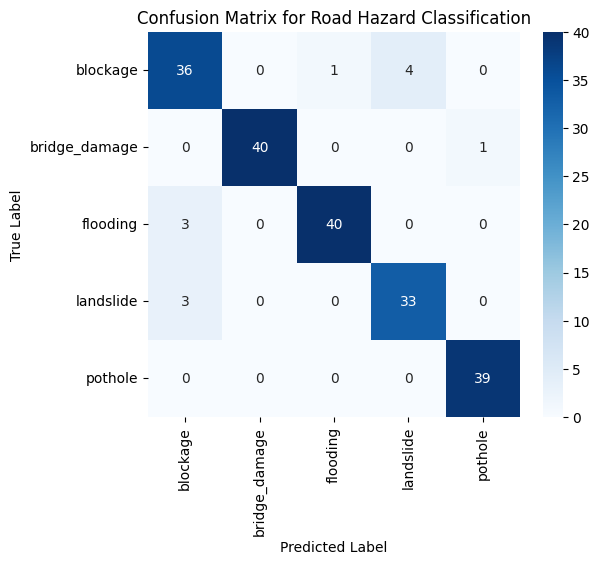

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Road Hazard Classification")
plt.show()


In [15]:
model.save_pretrained("road_hazard_model")
tokenizer.save_pretrained("road_hazard_model")

('road_hazard_model/tokenizer_config.json',
 'road_hazard_model/special_tokens_map.json',
 'road_hazard_model/vocab.txt',
 'road_hazard_model/added_tokens.json',
 'road_hazard_model/tokenizer.json')

In [16]:
!pip install -q gradio transformers torch

In [17]:
import gradio as gr
import torch
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ============================
# Load trained model
# ============================
MODEL_PATH = "road_hazard_model"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
model.eval()

LABELS = ["blockage", "bridge_damage", "flooding", "landslide", "pothole"]

def classify_report(text):
    if not text.strip():
        return "❌ Please enter a report", {}

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()

    pred_idx = int(np.argmax(probs))
    pred_label = LABELS[pred_idx]

    confidence = {LABELS[i]: float(probs[i]) for i in range(len(LABELS))}

    return f"🛑 {pred_label.upper()}", confidence


demo = gr.Interface(
    fn=classify_report,
    inputs=gr.Textbox(
        lines=5,
        label="Citizen Road Hazard Report",
        placeholder="Example: Water logging and cracks on village road, tractors slipping"
    ),
    outputs=[
        gr.Textbox(label="Predicted Hazard"),
        gr.JSON(label="Confidence Scores")
    ],
    title="🚜 Road Hazard Report Normalization",
    description=(
        "This tool normalizes noisy citizen-reported road hazard texts into "
        "standardized categories for agriculture extension and rural planning."
    ),
    examples=[
        ["Water and mud on village road, tractors slipping"],
        ["Tree fallen blocking farm road, milk vans stuck"],
        ["Bridge cracked and water leaking, unsafe for trucks"],
        ["Soil sliding onto hill road after heavy rain"]
    ],
    theme="soft"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://24b7efd3e6cc07b0d6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
